In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

In [ ]:
import dask.dataframe as dd
import pandas as pd
import os

folder_path = '/content/drive/MyDrive/parquet_stations'
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.parquet')]

daily_dfs = []

for file in all_files:
    # ƒê·ªçc b·∫±ng Pandas
    df = pd.read_parquet(file)

    # Drop c√°c c·ªôt kh√¥ng c·∫ßn thi·∫øt s·ªõm ƒë·ªÉ ti·∫øt ki·ªám RAM/t√≠nh to√°n
    df = df.drop(columns=['WND_ANGLE', 'WND_RATE', 'SLP', 'MASK', 'TIME_DIFF'], errors='ignore')

    # Chuy·ªÉn DATE v·ªÅ datetime
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.set_index('DATE')

    # Resample theo ng√†y: trung b√¨nh
    daily_df = df.resample('1D').mean().reset_index()

    # Gi·ªØ l·∫°i LONGITUDE & LATITUDE c·ªßa tr·∫°m
    if 'LONGITUDE' in df.columns and 'LATITUDE' in df.columns:
        lon = df['LONGITUDE'].iloc[0]
        lat = df['LATITUDE'].iloc[0]
        daily_df['LONGITUDE'] = lon
        daily_df['LATITUDE'] = lat

    daily_dfs.append(daily_df)

# G·ªôp t·∫•t c·∫£ l·∫°i th√†nh m·ªôt Dask dataframe
combined_df = dd.from_pandas(pd.concat(daily_dfs, ignore_index=True), npartitions=4)

# Ki·ªÉm tra
print(combined_df.head())


        DATE  LONGITUDE   LATITUDE       TMP       DEW
0 2014-01-01  27.183333  60.283333  2.997917  1.397917
1 2014-01-02  27.183333  60.283333  0.483333 -1.475000
2 2014-01-03  27.183333  60.283333  0.991667 -0.804167
3 2014-01-04  27.183333  60.283333  2.212500  1.012500
4 2014-01-05  27.183333  60.283333  4.025000  3.395833


In [ ]:
station_features = combined_df.groupby(['LONGITUDE', 'LATITUDE']).agg({
    'TMP': ['mean', 'std'],
    'DEW': ['mean', 'std'],
}).compute().reset_index()

station_features.columns = ['LONGITUDE', 'LATITUDE', 'TMP_mean', 'TMP_std', 'DEW_mean', 'DEW_std']

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = station_features[['TMP_mean', 'TMP_std']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
station_features['cluster'] = kmeans.fit_predict(X_scaled)

In [ ]:
combined_df = combined_df.merge(station_features[['LONGITUDE', 'LATITUDE', 'cluster']],
                                on=['LONGITUDE', 'LATITUDE'], how='left')

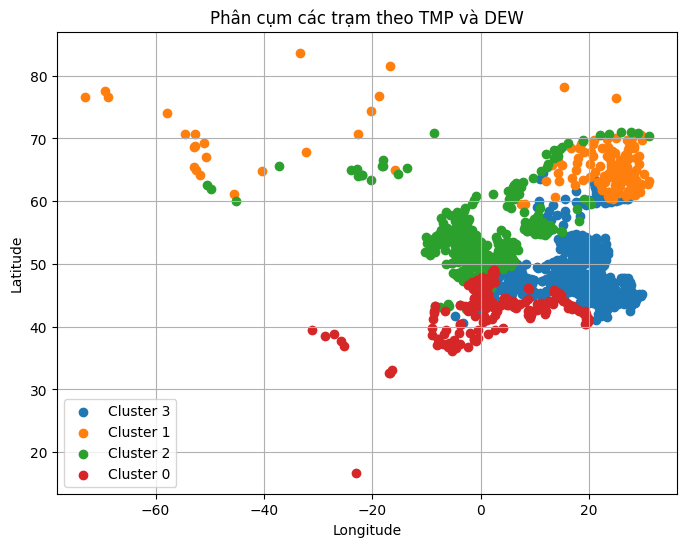

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for c in station_features['cluster'].unique():
    cluster_data = station_features[station_features['cluster'] == c]
    plt.scatter(cluster_data['LONGITUDE'], cluster_data['LATITUDE'], label=f'Cluster {c}')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Ph√¢n c·ª•m c√°c tr·∫°m theo TMP v√† DEW")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df = combined_df.compute()

In [ ]:
df

DATE  LONGITUDE   LATITUDE        TMP        DEW  cluster
0       2014-01-01  27.183333  60.283333   2.997917   1.397917        3
1       2014-01-02  27.183333  60.283333   0.483333  -1.475000        3
2       2014-01-03  27.183333  60.283333   0.991667  -0.804167        3
3       2014-01-04  27.183333  60.283333   2.212500   1.012500        3
4       2014-01-05  27.183333  60.283333   4.025000   3.395833        3
...            ...        ...        ...        ...        ...      ...
1095595 2023-12-27  28.144397  61.044553 -11.595833 -12.916667        1
1095596 2023-12-28  28.144397  61.044553  -6.400000  -7.262500        1
1095597 2023-12-29  28.144397  61.044553  -4.283333  -4.950000        1
1095598 2023-12-30  28.144397  61.044553  -7.904167  -9.200000        1
1095599 2023-12-31  28.144397  61.044553 -14.450000 -16.304167        1

[4382400 rows x 6 columns]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import joblib
import warnings
warnings.filterwarnings('ignore')

class TemperaturePredictionModel:
    def __init__(self):
        self.model = LinearRegression()
        self.scaler = StandardScaler()
        self.is_trained = False  # Th√™m d√≤ng n√†y
        self.feature_names = []

    def create_features(self, df):
        """T·∫°o c√°c feature t·ª´ d·ªØ li·ªáu th·ªùi gian v√† v·ªã tr√≠"""
        df = df.copy()
        df['DATE'] = pd.to_datetime(df['DATE'])

        # Features t·ª´ th·ªùi gian
        df['year'] = df['DATE'].dt.year
        df['month'] = df['DATE'].dt.month
        df['day_of_year'] = df['DATE'].dt.dayofyear
        df['day_of_month'] = df['DATE'].dt.day

        # Features chu k·ª≥ (sin/cos ƒë·ªÉ capture t√≠nh tu·∫ßn ho√†n)
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
        df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

        # Features v·ªã tr√≠
        df['lat_lon_interaction'] = df['LATITUDE'] * df['LONGITUDE']
        df['distance_from_equator'] = np.abs(df['LATITUDE'])

        # S·∫Øp x·∫øp theo th·ªùi gian ƒë·ªÉ t·∫°o lag features
        df = df.sort_values(['LONGITUDE', 'LATITUDE', 'DATE'])

        df_dew_available = df.dropna(subset=['DEW']).copy()

        if not df_dew_available.empty:
            # T√≠nh trung b√¨nh DEW theo Longitude, Latitude, v√† Day of Year
            # S·ª≠ d·ª•ng .reset_index() ƒë·ªÉ chuy·ªÉn groupby keys th√†nh c·ªôt
            seasonal_dew_avg = df_dew_available.groupby(['LONGITUDE', 'LATITUDE', 'day_of_year'])['DEW'].mean().reset_index()
            seasonal_dew_avg.rename(columns={'DEW': 'seasonal_dew_avg'}, inplace=True)

            # 2. Merge gi√° tr·ªã DEW trung b√¨nh theo m√πa v√†o DataFrame g·ªëc
            # Merge d·ª±a tr√™n Longitude, Latitude, v√† Day of Year
            df = df.merge(seasonal_dew_avg, on=['LONGITUDE', 'LATITUDE', 'day_of_year'], how='left')

            # 3. ƒêi·ªÅn c√°c gi√° tr·ªã NaN trong c·ªôt DEW g·ªëc b·∫±ng gi√° tr·ªã seasonal_dew_avg
            # Ch·ªâ ƒëi·ªÅn cho nh·ªØng h√†ng m√† DEW ban ƒë·∫ßu l√† NaN
            df['DEW'] = df['DEW'].fillna(df['seasonal_dew_avg'])

            # X√≥a c·ªôt trung gian seasonal_dew_avg
            df = df.drop(columns=['seasonal_dew_avg'])

        # Lag features (nhi·ªát ƒë·ªô ng√†y tr∆∞·ªõc)
        df['temp_lag_1'] = df.groupby(['LONGITUDE', 'LATITUDE'])['TMP'].shift(1)
        df['temp_lag_7'] = df.groupby(['LONGITUDE', 'LATITUDE'])['TMP'].shift(7)
        df['temp_lag_30'] = df.groupby(['LONGITUDE', 'LATITUDE'])['TMP'].shift(30)

        # Moving averages - c√°ch an to√†n h∆°n
        df['temp_ma_7'] = df.groupby(['LONGITUDE', 'LATITUDE'])['TMP'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
        df['temp_ma_30'] = df.groupby(['LONGITUDE', 'LATITUDE'])['TMP'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

        df['DEW_lag_year'] = df.groupby(['LONGITUDE', 'LATITUDE'])['DEW'].shift(365) # S·ª≠ d·ª•ng DEW ƒë√£ fillna theo m√πa

        # Trend feature (s·ªë ng√†y t·ª´ ng√†y ƒë·∫ßu ti√™n)
        df['days_from_start'] = (df['DATE'] - df['DATE'].min()).dt.days

        return df

    def prepare_data(self, df):
        """Chu·∫©n b·ªã d·ªØ li·ªáu cho training"""
        df_features = self.create_features(df)

        # Ch·ªçn features cho model
        feature_cols = [
            'LONGITUDE', 'LATITUDE',
            'DEW',
            'DEW_lag_year',
            'cluster',
            'year', 'month', 'day_of_year', 'day_of_month',
            'month_sin', 'month_cos', 'day_sin', 'day_cos',
            'lat_lon_interaction', 'distance_from_equator',
            'temp_lag_1', 'temp_lag_7', 'temp_lag_30',
            'temp_ma_7', 'temp_ma_30', 'days_from_start'
        ]

        self.feature_names = feature_cols

        # Lo·∫°i b·ªè rows c√≥ NaN (do lag features)
        df_clean = df_features.dropna(subset=self.feature_names + ['TMP'])

        X = df_clean[feature_cols]
        y = df_clean['TMP']

        return X, y, df_clean

    def train(self, df, test_size=0.2):
        """Training model"""
        print("ƒêang chu·∫©n b·ªã d·ªØ li·ªáu...")
        X, y, df_clean = self.prepare_data(df)

        print(f"S·ªë l∆∞·ª£ng samples sau khi l√†m s·∫°ch: {len(X)}")
        print(f"Features ƒë∆∞·ª£c s·ª≠ d·ª•ng: {len(self.feature_names)}")

        # Chia train/test theo th·ªùi gian (test set l√† d·ªØ li·ªáu g·∫ßn ƒë√¢y nh·∫•t)
        df_clean = df_clean.sort_values('DATE')
        split_idx = int(len(df_clean) * (1 - test_size))

        X_train = X.iloc[:split_idx]
        X_test = X.iloc[split_idx:]
        y_train = y.iloc[:split_idx]
        y_test = y.iloc[split_idx:]

        print("ƒêang training model...")

        # Chu·∫©n h√≥a d·ªØ li·ªáu
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Training
        self.model.fit(X_train_scaled, y_train)

        # ƒê√°nh gi√°
        train_pred = self.model.predict(X_train_scaled)
        test_pred = self.model.predict(X_test_scaled)

        train_mae = mean_absolute_error(y_train, train_pred)
        test_mae = mean_absolute_error(y_test, test_pred)
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)

        print(f"\n=== K·∫æT QU·∫¢ TRAINING ===")
        print(f"Train MAE: {train_mae:.3f}¬∞C")
        print(f"Test MAE: {test_mae:.3f}¬∞C")
        print(f"Train R¬≤: {train_r2:.3f}")
        print(f"Test R¬≤: {test_r2:.3f}")

        self.is_trained = True # Set True sau khi train

        return {
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_r2': train_r2,
            'test_r2': test_r2
        }

    def predict(self, df):
        """D·ª± ƒëo√°n nhi·ªát ƒë·ªô"""
        if not self.is_trained:
            raise ValueError("Model ch∆∞a ƒë∆∞·ª£c training!")

        df_features = self.create_features(df)
        X = df_features[self.feature_names]

        # Handle missing values b·∫±ng c√°ch fill
        # S·ª≠ d·ª•ng fillna(method='ffill').fillna(method='bfill') tr∆∞·ªõc khi fillna(0)
        # ƒë·ªÉ gi·ªØ l·∫°i c√°c gi√° tr·ªã l√¢n c·∫≠n n·∫øu c√≥
        X = X.fillna(method='ffill').fillna(method='bfill')
        X = X.fillna(0) # Fill remaining NaNs, e.g., at the beginning of series


        X_scaled = self.scaler.transform(X)
        predictions = self.model.predict(X_scaled)

        return predictions

    def save_model(self, filepath):
        """L∆∞u model"""
        if not self.is_trained:
            raise ValueError("Model ch∆∞a ƒë∆∞·ª£c training!")

        model_data = {
            'model': self.model,
            'scaler': self.scaler,
            'feature_names': self.feature_names,
            'is_trained': self.is_trained
        }
        joblib.dump(model_data, filepath)
        print(f"Model ƒë√£ ƒë∆∞·ª£c l∆∞u t·∫°i: {filepath}")

    def load_model(self, filepath):
        """Load model"""
        model_data = joblib.load(filepath)
        self.model = model_data['model']
        self.scaler = model_data['scaler']
        self.feature_names = model_data['feature_names']
        self.is_trained = model_data['is_trained'] # Load l·∫°i tr·∫°ng th√°i is_trained
        print(f"Model ƒë√£ ƒë∆∞·ª£c load t·ª´: {filepath}")

    def predict_single(self, longitude, latitude, date, dew, cluster):
        """D·ª± ƒëo√°n cho m·ªôt ƒëi·ªÉm d·ªØ li·ªáu ƒë∆°n l·∫ª"""
        # T·∫°o DataFrame t·ª´ input
        df_single = pd.DataFrame({
            'DATE': [pd.to_datetime(date)],
            'LONGITUDE': [longitude],
            'LATITUDE': [latitude],
            'DEW': [dew],
            'cluster': [cluster],
            'TMP': [0]  # Dummy value
        })

        try:
            # S·ª≠ d·ª•ng ph∆∞∆°ng th·ª©c predict chung, n√≥ s·∫Ω x·ª≠ l√Ω feature engineering v√† scaling
            prediction = self.predict(df_single)
            return prediction[0]
        except Exception as e:
            print(f"L·ªói khi d·ª± ƒëo√°n ƒëi·ªÉm ƒë∆°n l·∫ª b·∫±ng model ƒë√£ train: {e}")
            # Fallback: d·ª± ƒëo√°n ƒë∆°n gi·∫£n d·ª±a tr√™n DEW v√† v·ªã tr√≠ (nh∆∞ ban ƒë·∫ßu)
            print("Th·ª±c hi·ªán d·ª± ƒëo√°n ƒë∆°n gi·∫£n l√†m fallback...")
            base_temp = dew + 5  # Rough estimate
            date_obj = pd.to_datetime(date)
            seasonal_factor = np.sin(2 * np.pi * date_obj.dayofyear / 365) * 10
            lat_factor = -abs(latitude * 0.5)
            return base_temp + seasonal_factor + lat_factor
def create_evaluator_from_trained_model(model, df, test_ratio=0.2):
    """T·∫°o evaluator t·ª´ model ƒë√£ ƒë∆∞·ª£c train"""

    # Recreate the data processing
    df_features = model.create_features(df)
    feature_cols = model.feature_names # L·∫•y feature_names ƒë√£ c·∫≠p nh·∫≠t t·ª´ model

    df_clean = df_features.dropna(subset=[f for f in feature_cols + ['TMP'] if f in df_features.columns])
    X = df_clean[feature_cols]
    y = df_clean['TMP']

    # Split data
    df_clean = df_clean.sort_values('DATE')
    split_idx = int(len(df_clean) * (1 - test_ratio))

    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]

    # Scale data
    X_train_scaled = model.scaler.transform(X_train) # S·ª≠ d·ª•ng scaler ƒë√£ fit trong model
    X_test_scaled = model.scaler.transform(X_test)

    # Create evaluator
    evaluator = ModelEvaluator(
        model.model, X_train_scaled, X_test_scaled,
        y_train, y_test, feature_cols # Truy·ªÅn feature_cols ƒë√£ c·∫≠p nh·∫≠t
    )

    return evaluator, df_clean.iloc[split_idx:]

# V√≠ d·ª• s·ª≠ d·ª•ng
def demo_usage():
    """V√≠ d·ª• c√°ch s·ª≠ d·ª•ng model"""
    # Training model
    print("\n=== TRAINING MODEL ===")
    model = TemperaturePredictionModel()
    results = model.train(df)

    # L∆∞u model
    model.save_model('temperature_model.pkl')

    return model

if __name__ == "__main__":
    # Ch·∫°y demo
    model = demo_usage()


=== TRAINING MODEL ===
ƒêang chu·∫©n b·ªã d·ªØ li·ªáu...
S·ªë l∆∞·ª£ng samples sau khi l√†m s·∫°ch: 3944765
Features ƒë∆∞·ª£c s·ª≠ d·ª•ng: 21
ƒêang training model...

=== K·∫æT QU·∫¢ TRAINING ===
Train MAE: 1.346¬∞C
Test MAE: 1.536¬∞C
Train R¬≤: 0.949
Test R¬≤: 0.958
Model ƒë√£ ƒë∆∞·ª£c l∆∞u t·∫°i: temperature_model.pkl


Model ƒë√£ ƒë∆∞·ª£c load t·ª´: temperature_model.pkl
B·∫Øt ƒë·∫ßu ƒë√°nh gi√° to√†n di·ªán...
           B√ÅOC√ÅO ƒê√ÅNH GI√Å HI·ªÜU SU·∫§T MODEL

üìä METRICS T·ªîNG QUAN:
----------------------------------------
Metric          Train        Test         Diff        
----------------------------------------
MAE (¬∞C)        3.095        2.741        0.354       
RMSE (¬∞C)       3.592        3.204        0.388       
R¬≤ Score        0.782        0.831        0.049       

=== K·∫æT QU·∫¢ ƒê√ÅNH GI√Å ===
Train MSE: 12.903
Test MSE: 10.264
Train RMSE: 3.592
Test RMSE: 3.204

üéØ ƒê√ÅNH GI√Å CH·∫§T L∆Ø·ª¢NG:
----------------------------------------
ƒê·ªô ch√≠nh x√°c (MAE): T·ªët ‚≠ê‚≠ê‚≠ê‚≠ê
Kh·∫£ nƒÉng gi·∫£i th√≠ch (R¬≤): T·ªët ‚≠ê‚≠ê‚≠ê‚≠ê
T√¨nh tr·∫°ng overfitting: Kh√¥ng overfitting ‚úÖ

üìà PH√ÇN T√çCH CHI TI·∫æT:
----------------------------------------
‚Ä¢ L·ªói trung b√¨nh: 2.74¬∞C
‚Ä¢ 95% d·ª± ƒëo√°n trong kho·∫£ng: ¬±6.28¬∞C
‚Ä¢ Model gi·∫£i th√≠ch ƒë∆∞·ª£c 83.1% bi·∫øn thi

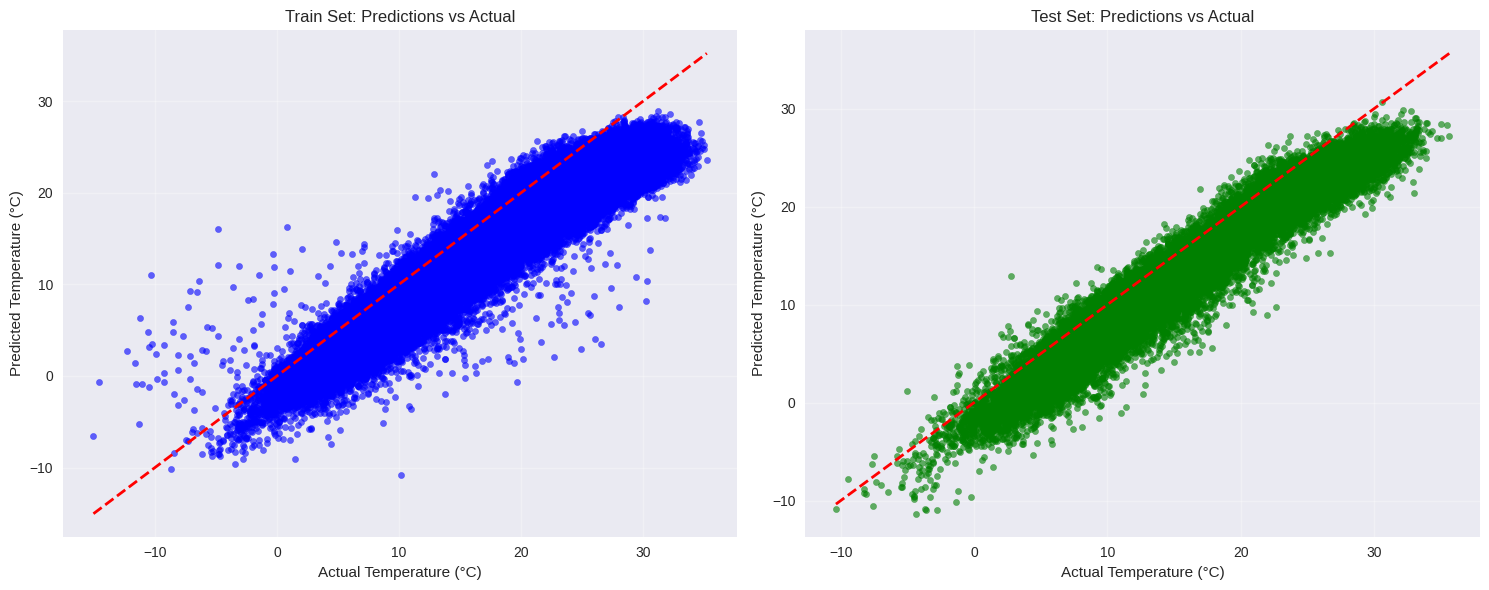

2. V·∫Ω bi·ªÉu ƒë·ªì Residuals...


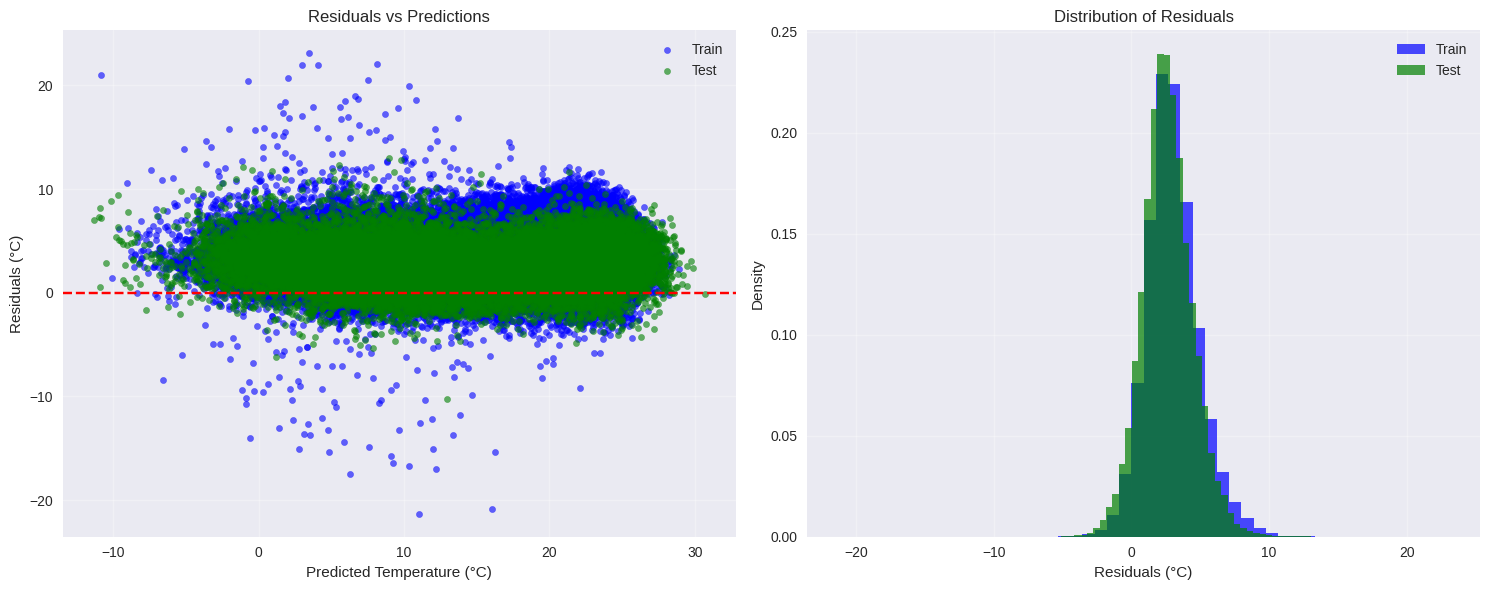

3. V·∫Ω bi·ªÉu ƒë·ªì Feature Importance...


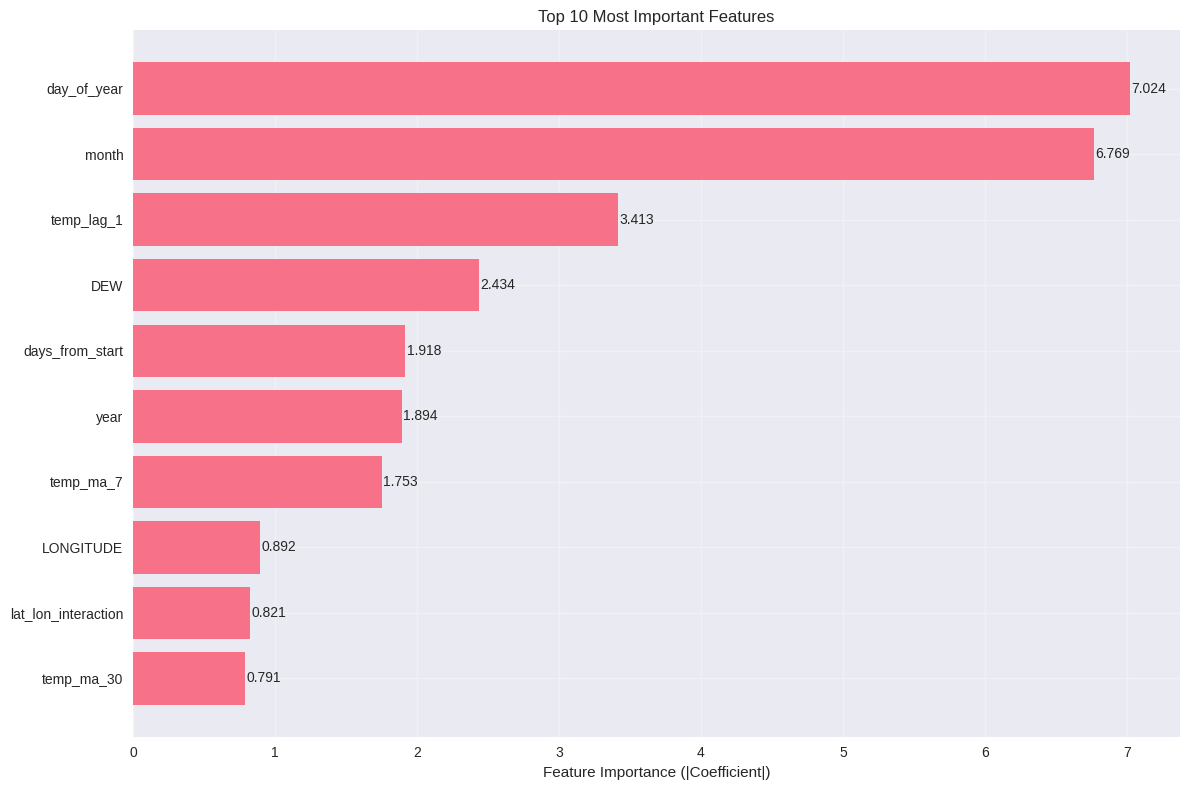


‚úÖ Ho√†n th√†nh ƒë√°nh gi√°!
=== V√ç D·ª§ ƒê√ÅNH GI√Å MODEL ===


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class ModelEvaluator:
    """C√¥ng c·ª• ƒë√°nh gi√° v√† tr·ª±c quan h√≥a hi·ªáu su·∫•t model"""

    def __init__(self, model, X_train, X_test, y_train, y_test, feature_names):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.feature_names = feature_names

        # Predictions
        self.y_train_pred = model.predict(X_train)
        self.y_test_pred = model.predict(X_test)

    def calculate_metrics(self):
        """T√≠nh to√°n c√°c metrics ƒë√°nh gi√°"""
        metrics = {}

        # Train metrics
        metrics['train_mae'] = mean_absolute_error(self.y_train, self.y_train_pred)
        metrics['train_mse'] = mean_squared_error(self.y_train, self.y_train_pred)
        metrics['train_rmse'] = np.sqrt(metrics['train_mse'])
        metrics['train_r2'] = r2_score(self.y_train, self.y_train_pred)
        metrics['train_mape'] = mean_absolute_percentage_error(self.y_train, self.y_train_pred)

        # Test metrics
        metrics['test_mae'] = mean_absolute_error(self.y_test, self.y_test_pred)
        metrics['test_mse'] = mean_squared_error(self.y_test, self.y_test_pred)
        metrics['test_rmse'] = np.sqrt(metrics['test_mse'])
        metrics['test_r2'] = r2_score(self.y_test, self.y_test_pred)
        metrics['test_mape'] = mean_absolute_percentage_error(self.y_test, self.y_test_pred)

        return metrics

    def plot_predictions_vs_actual(self, figsize=(15, 6)):
        """Bi·ªÉu ƒë·ªì so s√°nh predictions vs actual"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Train set
        ax1.scatter(self.y_train, self.y_train_pred, alpha=0.6, color='blue', s=20)
        ax1.plot([self.y_train.min(), self.y_train.max()],
                [self.y_train.min(), self.y_train.max()], 'r--', lw=2)
        ax1.set_xlabel('Actual Temperature (¬∞C)')
        ax1.set_ylabel('Predicted Temperature (¬∞C)')
        ax1.set_title('Train Set: Predictions vs Actual')
        ax1.grid(True, alpha=0.3)

        # Test set
        ax2.scatter(self.y_test, self.y_test_pred, alpha=0.6, color='green', s=20)
        ax2.plot([self.y_test.min(), self.y_test.max()],
                [self.y_test.min(), self.y_test.max()], 'r--', lw=2)
        ax2.set_xlabel('Actual Temperature (¬∞C)')
        ax2.set_ylabel('Predicted Temperature (¬∞C)')
        ax2.set_title('Test Set: Predictions vs Actual')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_residuals(self, figsize=(15, 6)):
        """Bi·ªÉu ƒë·ªì residuals ƒë·ªÉ ki·ªÉm tra pattern"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Residuals vs Predictions
        train_residuals = self.y_train - self.y_train_pred
        test_residuals = self.y_test - self.y_test_pred

        ax1.scatter(self.y_train_pred, train_residuals, alpha=0.6, color='blue', s=20, label='Train')
        ax1.scatter(self.y_test_pred, test_residuals, alpha=0.6, color='green', s=20, label='Test')
        ax1.axhline(y=0, color='r', linestyle='--')
        ax1.set_xlabel('Predicted Temperature (¬∞C)')
        ax1.set_ylabel('Residuals (¬∞C)')
        ax1.set_title('Residuals vs Predictions')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Histogram of residuals
        ax2.hist(train_residuals, bins=50, alpha=0.7, color='blue', label='Train', density=True)
        ax2.hist(test_residuals, bins=50, alpha=0.7, color='green', label='Test', density=True)
        ax2.set_xlabel('Residuals (¬∞C)')
        ax2.set_ylabel('Density')
        ax2.set_title('Distribution of Residuals')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, top_n=10, figsize=(12, 8)):
        """Bi·ªÉu ƒë·ªì feature importance"""
        if hasattr(self.model, 'coef_'):
            importance = np.abs(self.model.coef_)
            feature_importance = pd.DataFrame({
                'feature': self.feature_names,
                'importance': importance
            }).sort_values('importance', ascending=False)

            plt.figure(figsize=figsize)
            top_features = feature_importance.head(top_n)

            bars = plt.barh(range(len(top_features)), top_features['importance'])
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Feature Importance (|Coefficient|)')
            plt.title(f'Top {top_n} Most Important Features')
            plt.gca().invert_yaxis()

            # Add value labels on bars
            for i, (bar, val) in enumerate(zip(bars, top_features['importance'])):
                plt.text(val + 0.01, bar.get_y() + bar.get_height()/2,
                        f'{val:.3f}', va='center', fontsize=10)

            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

            return feature_importance
        else:
            print("Model kh√¥ng c√≥ feature importance (coef_)")
            return None

    def plot_error_analysis(self, figsize=(15, 10)):
        """Ph√¢n t√≠ch l·ªói chi ti·∫øt"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)

        # Error by temperature range
        test_errors = np.abs(self.y_test - self.y_test_pred)
        temp_ranges = pd.cut(self.y_test, bins=10)
        error_by_temp = pd.DataFrame({
            'temp_range': temp_ranges,
            'error': test_errors
        }).groupby('temp_range')['error'].mean()

        ax1.bar(range(len(error_by_temp)), error_by_temp.values)
        ax1.set_xticks(range(len(error_by_temp)))
        ax1.set_xticklabels([f'{i.left:.1f}-{i.right:.1f}' for i in error_by_temp.index], rotation=45)
        ax1.set_ylabel('Mean Absolute Error (¬∞C)')
        ax1.set_title('Error by Temperature Range')
        ax1.grid(True, alpha=0.3)

        # Error distribution
        ax2.boxplot([np.abs(self.y_train - self.y_train_pred),
                    np.abs(self.y_test - self.y_test_pred)],
                   labels=['Train', 'Test'])
        ax2.set_ylabel('Absolute Error (¬∞C)')
        ax2.set_title('Error Distribution')
        ax2.grid(True, alpha=0.3)

        # Cumulative error
        test_errors_sorted = np.sort(test_errors)
        cumulative_pct = np.arange(1, len(test_errors_sorted) + 1) / len(test_errors_sorted) * 100
        ax3.plot(test_errors_sorted, cumulative_pct)
        ax3.set_xlabel('Absolute Error (¬∞C)')
        ax3.set_ylabel('Cumulative Percentage (%)')
        ax3.set_title('Cumulative Error Distribution')
        ax3.grid(True, alpha=0.3)

        # Error vs actual temperature
        ax4.scatter(self.y_test, test_errors, alpha=0.6, s=20)
        ax4.set_xlabel('Actual Temperature (¬∞C)')
        ax4.set_ylabel('Absolute Error (¬∞C)')
        ax4.set_title('Error vs Actual Temperature')
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_time_series_sample(self, df_test, sample_stations=3, figsize=(15, 8)):
        """Bi·ªÉu ƒë·ªì time series cho m·ªôt s·ªë tr·∫°m m·∫´u"""
        if 'DATE' not in df_test.columns:
            print("C·∫ßn c√≥ column DATE ƒë·ªÉ v·∫Ω time series")
            return

        # L·∫•y m·ªôt s·ªë tr·∫°m m·∫´u
        unique_stations = df_test.groupby(['LONGITUDE', 'LATITUDE']).size().head(sample_stations).index

        fig, axes = plt.subplots(sample_stations, 1, figsize=figsize)
        if sample_stations == 1:
            axes = [axes]

        for i, (lon, lat) in enumerate(unique_stations):
            station_data = df_test[(df_test['LONGITUDE'] == lon) & (df_test['LATITUDE'] == lat)].copy()
            station_data = station_data.sort_values('DATE')

            if len(station_data) > 0:
                axes[i].plot(station_data['DATE'], station_data['TMP'],
                           label='Actual', linewidth=2, alpha=0.8)

                # N·∫øu c√≥ predictions trong data
                if 'TMP_PRED' in station_data.columns:
                    axes[i].plot(station_data['DATE'], station_data['TMP_PRED'],
                               label='Predicted', linewidth=2, alpha=0.8)

                axes[i].set_title(f'Station ({lon:.2f}, {lat:.2f})')
                axes[i].set_ylabel('Temperature (¬∞C)')
                axes[i].legend()
                axes[i].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def generate_report(self):
        """T·∫°o b√°o c√°o t·ªïng quan"""
        metrics = self.calculate_metrics()

        print("="*60)
        print("           B√ÅOC√ÅO ƒê√ÅNH GI√Å HI·ªÜU SU·∫§T MODEL")
        print("="*60)

        print(f"\nüìä METRICS T·ªîNG QUAN:")
        print("-" * 40)
        print(f"{'Metric':<15} {'Train':<12} {'Test':<12} {'Diff':<12}")
        print("-" * 40)
        print(f"{'MAE (¬∞C)':<15} {metrics['train_mae']:<12.3f} {metrics['test_mae']:<12.3f} {abs(metrics['train_mae'] - metrics['test_mae']):<12.3f}")
        print(f"{'RMSE (¬∞C)':<15} {metrics['train_rmse']:<12.3f} {metrics['test_rmse']:<12.3f} {abs(metrics['train_rmse'] - metrics['test_rmse']):<12.3f}")
        print(f"{'R¬≤ Score':<15} {metrics['train_r2']:<12.3f} {metrics['test_r2']:<12.3f} {abs(metrics['train_r2'] - metrics['test_r2']):<12.3f}")
        print("\n=== K·∫æT QU·∫¢ ƒê√ÅNH GI√Å ===")
        print(f"Train MSE: {metrics['train_mse']:.3f}")
        print(f"Test MSE: {metrics['test_mse']:.3f}")
        print(f"Train RMSE: {metrics['train_rmse']:.3f}")
        print(f"Test RMSE: {metrics['test_rmse']:.3f}")
        print(f"\nüéØ ƒê√ÅNH GI√Å CH·∫§T L∆Ø·ª¢NG:")
        print("-" * 40)

        # ƒê√°nh gi√° MAE
        if metrics['test_mae'] <= 2:
            mae_rating = "Xu·∫•t s·∫Øc ‚≠ê‚≠ê‚≠ê‚≠ê‚≠ê"
        elif metrics['test_mae'] <= 3:
            mae_rating = "T·ªët ‚≠ê‚≠ê‚≠ê‚≠ê"
        elif metrics['test_mae'] <= 5:
            mae_rating = "Kh√° ‚≠ê‚≠ê‚≠ê"
        else:
            mae_rating = "C·∫ßn c·∫£i thi·ªán ‚≠ê‚≠ê"

        # ƒê√°nh gi√° R¬≤
        if metrics['test_r2'] >= 0.9:
            r2_rating = "Xu·∫•t s·∫Øc ‚≠ê‚≠ê‚≠ê‚≠ê‚≠ê"
        elif metrics['test_r2'] >= 0.8:
            r2_rating = "T·ªët ‚≠ê‚≠ê‚≠ê‚≠ê"
        elif metrics['test_r2'] >= 0.7:
            r2_rating = "Kh√° ‚≠ê‚≠ê‚≠ê"
        else:
            r2_rating = "C·∫ßn c·∫£i thi·ªán ‚≠ê‚≠ê"

        # ƒê√°nh gi√° Overfitting
        mae_diff = abs(metrics['train_mae'] - metrics['test_mae'])
        if mae_diff <= 0.5:
            overfit_rating = "Kh√¥ng overfitting ‚úÖ"
        elif mae_diff <= 1.0:
            overfit_rating = "Overfitting nh·∫π ‚ö†Ô∏è"
        else:
            overfit_rating = "Overfitting nghi√™m tr·ªçng ‚ùå"

        print(f"ƒê·ªô ch√≠nh x√°c (MAE): {mae_rating}")
        print(f"Kh·∫£ nƒÉng gi·∫£i th√≠ch (R¬≤): {r2_rating}")
        print(f"T√¨nh tr·∫°ng overfitting: {overfit_rating}")

        print(f"\nüìà PH√ÇN T√çCH CHI TI·∫æT:")
        print("-" * 40)
        print(f"‚Ä¢ L·ªói trung b√¨nh: {metrics['test_mae']:.2f}¬∞C")
        print(f"‚Ä¢ 95% d·ª± ƒëo√°n trong kho·∫£ng: ¬±{metrics['test_rmse']*1.96:.2f}¬∞C")
        print(f"‚Ä¢ Model gi·∫£i th√≠ch ƒë∆∞·ª£c {metrics['test_r2']*100:.1f}% bi·∫øn thi√™n nhi·ªát ƒë·ªô")

        # Error percentiles
        test_errors = np.abs(self.y_test - self.y_test_pred)
        print(f"‚Ä¢ 90% d·ª± ƒëo√°n c√≥ l·ªói ‚â§ {np.percentile(test_errors, 90):.2f}¬∞C")
        print(f"‚Ä¢ 50% d·ª± ƒëo√°n c√≥ l·ªói ‚â§ {np.percentile(test_errors, 50):.2f}¬∞C")

        print(f"\nüí° KHUY·∫æN NGH·ªä:")
        print("-" * 40)
        if metrics['test_mae'] > 3:
            print("‚Ä¢ N√™n th√™m feature engineering ho·∫∑c d√πng model ph·ª©c t·∫°p h∆°n")
        if mae_diff > 1:
            print("‚Ä¢ N√™n th√™m regularization ƒë·ªÉ gi·∫£m overfitting")
        if metrics['test_r2'] < 0.8:
            print("‚Ä¢ N√™n ki·ªÉm tra v√† l√†m s·∫°ch d·ªØ li·ªáu outliers")
        if metrics['test_mae'] <= 2 and metrics['test_r2'] >= 0.85:
            print("‚Ä¢ Model ƒë·∫°t ch·∫•t l∆∞·ª£ng t·ªët, s·∫µn s√†ng production! üöÄ")

        return metrics

    def comprehensive_evaluation(self, df_test=None):
        """ƒê√°nh gi√° to√†n di·ªán v·ªõi t·∫•t c·∫£ bi·ªÉu ƒë·ªì"""
        print("B·∫Øt ƒë·∫ßu ƒë√°nh gi√° to√†n di·ªán...")

        # 1. B√°o c√°o metrics
        metrics = self.generate_report()

        # 2. Bi·ªÉu ƒë·ªì predictions vs actual
        print("\n1. V·∫Ω bi·ªÉu ƒë·ªì Predictions vs Actual...")
        self.plot_predictions_vs_actual()

        # 3. Bi·ªÉu ƒë·ªì residuals
        print("2. V·∫Ω bi·ªÉu ƒë·ªì Residuals...")
        self.plot_residuals()

        # 4. Feature importance
        print("3. V·∫Ω bi·ªÉu ƒë·ªì Feature Importance...")
        feature_imp = self.plot_feature_importance()

        print("\n‚úÖ Ho√†n th√†nh ƒë√°nh gi√°!")
        return metrics, feature_imp

# H√†m t·∫°o evaluator t·ª´ model ƒë√£ train
def create_evaluator_from_trained_model(model, df, test_ratio=0.2):
    """T·∫°o evaluator t·ª´ model ƒë√£ ƒë∆∞·ª£c train"""

    # Recreate the data processing
    df_features = model.create_features(df)
    feature_cols = model.feature_names

    df_clean = df_features.dropna(subset=feature_cols + ['TMP'])
    X = df_clean[feature_cols]
    y = df_clean['TMP']

    # Split data
    df_clean = df_clean.sort_values('DATE')
    split_idx = int(len(df_clean) * (1 - test_ratio))

    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]

    # Scale data
    X_train_scaled = model.scaler.transform(X_train)
    X_test_scaled = model.scaler.transform(X_test)

    # Create evaluator
    evaluator = ModelEvaluator(
        model.model, X_train_scaled, X_test_scaled,
        y_train, y_test, feature_cols
    )

    return evaluator, df_clean.iloc[split_idx:]

# V√≠ d·ª• s·ª≠ d·ª•ng
def example_usage():
    """V√≠ d·ª• c√°ch s·ª≠ d·ª•ng v·ªõi model ƒë√£ train"""

    print("=== V√ç D·ª§ ƒê√ÅNH GI√Å MODEL ===")

# 1. Load model v√† data
model = TemperaturePredictionModel()
model.load_model('temperature_model.pkl')
df = pd.read_parquet('/content/drive/MyDrive/clustered_parquet/cluster_19.parquet')

# 2. T·∫°o evaluator
evaluator, df_test = create_evaluator_from_trained_model(model, df)

# 3. ƒê√°nh gi√° to√†n di·ªán - s·∫Ω t·∫°o ra t·∫•t c·∫£ bi·ªÉu ƒë·ªì!
metrics, feature_importance = evaluator.comprehensive_evaluation(df_test)

if __name__ == "__main__":
    example_usage()

In [ ]:
df

DATE  LONGITUDE   LATITUDE        TMP       DEW  cluster
566060 2014-01-01   4.900000  43.900000   9.725000  4.620833       19
566061 2014-01-02   4.900000  43.900000  11.216667  8.804167       19
566062 2014-01-03   4.900000  43.900000  11.008333  8.150000       19
566063 2014-01-04   4.900000  43.900000  12.029167  9.645833       19
566064 2014-01-05   4.900000  43.900000   8.616667  1.829167       19
...           ...        ...        ...        ...       ...      ...
365195 2023-12-27  12.064156  42.430183   9.853080  6.945892       19
365196 2023-12-28  12.064156  42.430183   9.312500  7.307292       19
365197 2023-12-29  12.064156  42.430183   9.920833  8.040625       19
365198 2023-12-30  12.064156  42.430183  10.770833  8.415625       19
365199 2023-12-31  12.064156  42.430183  10.647917  9.079167       19

[189904 rows x 6 columns]

In [ ]:
output_path = '/content/drive/MyDrive/output_df.csv'

df.to_csv(output_path, index=False)

print(f"DataFrame ƒë√£ ƒë∆∞·ª£c l∆∞u v·ªÅ {output_path}")

DataFrame ƒë√£ ƒë∆∞·ª£c l∆∞u v·ªÅ /content/drive/MyDrive/output_df.csv


Model ƒë√£ ƒë∆∞·ª£c load t·ª´: temperature_model.pkl
ƒêang d·ª± ƒëo√°n tr√™n DataFrame m·ªõi...
D·ª± ƒëo√°n ƒë√£ ƒë∆∞·ª£c th√™m v√†o DataFrame.
             DATE  LONGITUDE  LATITUDE        TMP       DEW  cluster  \
566060 2014-01-01        4.9      43.9   9.725000  4.620833       19   
566061 2014-01-02        4.9      43.9  11.216667  8.804167       19   
566062 2014-01-03        4.9      43.9  11.008333  8.150000       19   
566063 2014-01-04        4.9      43.9  12.029167  9.645833       19   
566064 2014-01-05        4.9      43.9   8.616667  1.829167       19   

        TMP_PREDICTED  
566060       8.978196  
566061      11.115392  
566062      12.249765  
566063      10.791051  
566064       9.219758  


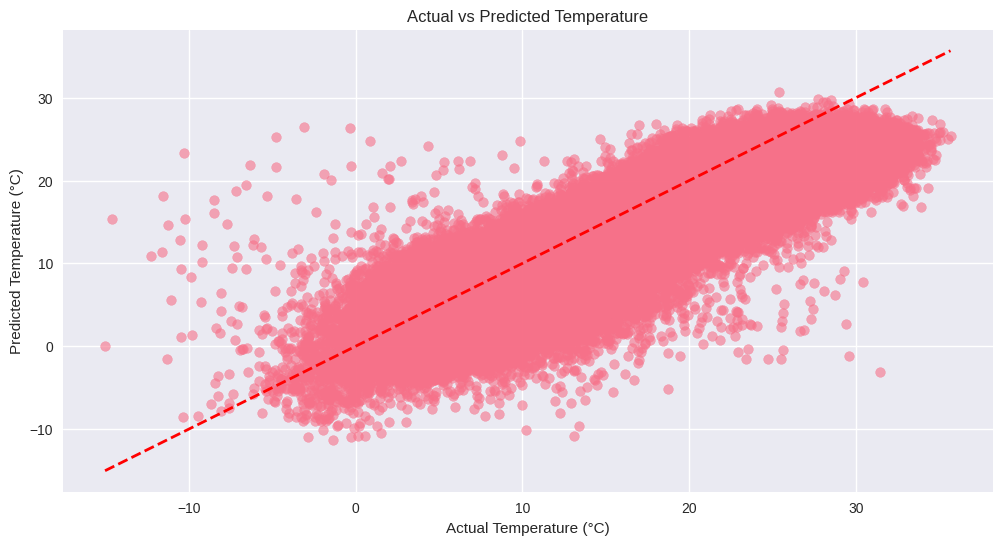

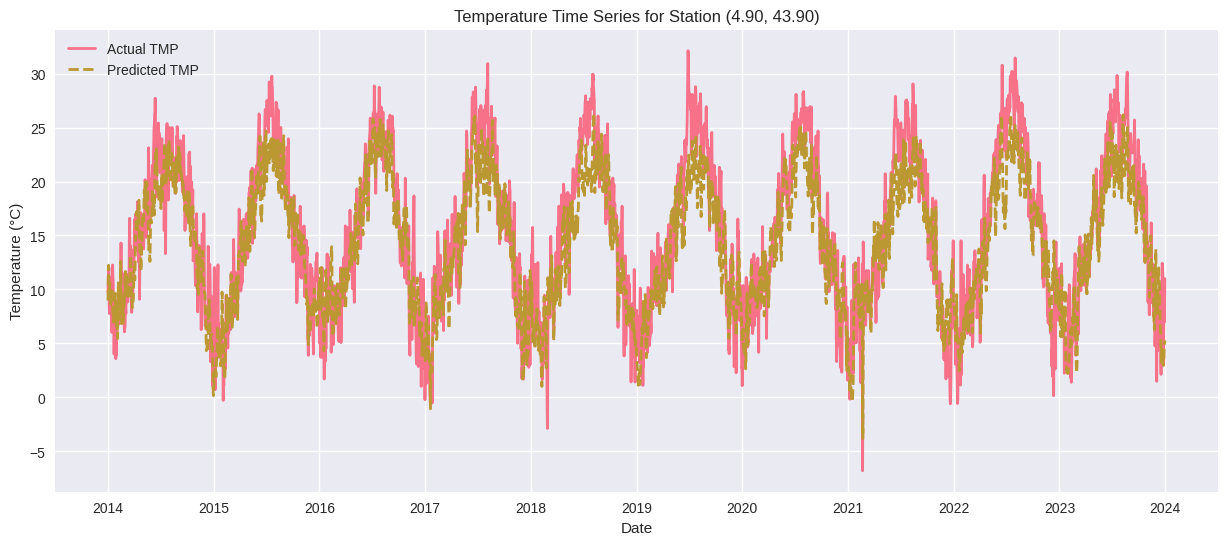

In [ ]:
model = TemperaturePredictionModel()
model.load_model('temperature_model.pkl')

# Gi·∫£ s·ª≠ b·∫°n c√≥ m·ªôt DataFrame m·ªõi mu·ªën d·ª± ƒëo√°n
# V√≠ d·ª•: d√πng l·∫°i DataFrame df ban ƒë·∫ßu, ho·∫∑c load t·ª´ m·ªôt ngu·ªìn kh√°c
df_to_predict = df.copy() # S·ª≠ d·ª•ng df ƒë√£ c√≥ trong notebook l√†m v√≠ d·ª•

# ƒê·∫£m b·∫£o c√°c c·ªôt c·∫ßn thi·∫øt cho create_features c√≥ m·∫∑t
# 'DATE', 'LONGITUDE', 'LATITUDE', 'DEW', 'cluster'

print("ƒêang d·ª± ƒëo√°n tr√™n DataFrame m·ªõi...")

# S·ª≠ d·ª•ng ph∆∞∆°ng th·ª©c predict c·ªßa model
# Ph∆∞∆°ng th·ª©c n√†y ƒë√£ bao g·ªìm b∆∞·ªõc t·∫°o features v√† scaling
predictions = model.predict(df_to_predict)

# Th√™m c·ªôt d·ª± ƒëo√°n v√†o DataFrame ban ƒë·∫ßu ho·∫∑c DataFrame m·ªõi
df_to_predict['TMP_PREDICTED'] = predictions

print("D·ª± ƒëo√°n ƒë√£ ƒë∆∞·ª£c th√™m v√†o DataFrame.")
print(df_to_predict.head())

# --- V·∫Ω bi·ªÉu ƒë·ªì so s√°nh (v√≠ d·ª•) ---
# N·∫øu df_to_predict ch·ª©a c·∫£ gi√° tr·ªã TMP th·ª±c t·∫ø, b·∫°n c√≥ th·ªÉ so s√°nh
if 'TMP' in df_to_predict.columns:
    plt.figure(figsize=(12, 6))
    plt.scatter(df_to_predict['TMP'], df_to_predict['TMP_PREDICTED'], alpha=0.6)
    plt.plot([df_to_predict['TMP'].min(), df_to_predict['TMP'].max()],
             [df_to_predict['TMP'].min(), df_to_predict['TMP'].max()], 'r--', lw=2) # ƒê∆∞·ªùng y=x l√Ω t∆∞·ªüng
    plt.xlabel('Actual Temperature (¬∞C)')
    plt.ylabel('Predicted Temperature (¬∞C)')
    plt.title('Actual vs Predicted Temperature')
    plt.grid(True)
    plt.show()
else:
    print("DataFrame kh√¥ng c√≥ c·ªôt 'TMP' th·ª±c t·∫ø ƒë·ªÉ so s√°nh.")

# N·∫øu b·∫°n mu·ªën xem time series c·ªßa d·ª± ƒëo√°n cho m·ªôt tr·∫°m c·ª• th·ªÉ
# Ch·ªçn m·ªôt tr·∫°m m·∫´u (v√≠ d·ª• tr·∫°m ƒë·∫ßu ti√™n trong df_to_predict)
if not df_to_predict.empty:
    sample_station_coords = df_to_predict[['LONGITUDE', 'LATITUDE']].iloc[0].tolist()
    lon_sample, lat_sample = sample_station_coords

    station_data = df_to_predict[(df_to_predict['LONGITUDE'] == lon_sample) &
                                 (df_to_predict['LATITUDE'] == lat_sample)].copy()
    station_data = station_data.sort_values('DATE')

    if len(station_data) > 0:
        plt.figure(figsize=(15, 6))
        if 'TMP' in station_data.columns:
             plt.plot(station_data['DATE'], station_data['TMP'], label='Actual TMP', linewidth=2)
        plt.plot(station_data['DATE'], station_data['TMP_PREDICTED'], label='Predicted TMP', linewidth=2, linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Temperature (¬∞C)')
        plt.title(f'Temperature Time Series for Station ({lon_sample:.2f}, {lat_sample:.2f})')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Kh√¥ng t√¨m th·∫•y d·ªØ li·ªáu cho tr·∫°m m·∫´u ƒë·ªÉ v·∫Ω time series.")

In [ ]:
station_features[['LONGITUDE', 'LATITUDE', 'cluster']].drop_duplicates().dropna(subset=['LONGITUDE', 'LATITUDE']).to_csv('station_data.csv', index=False)